In [1]:
######################################################
#
# ReaSCAN: on the mission for AGI with language.
#
# Author: Zhengxuan Wu (wuzhengx@stanford.edu)
#
# Descriptions:
# This script is used as initial plannings for the 
# ReaSCAN engine. It illustrate how to integrate different
# parts together, such as Mini-Grid gym etc..
#
# Notes:
# 1. We will leverage gSCAN core engines but with extensive 
# modifications for ReaSCAN. This ensures fairness of 
# comparisions.
######################################################

In [2]:
from collections import namedtuple, OrderedDict
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product
import copy
import re
import random

from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *
from simulator import *

### Vocabulary Module

In [3]:
# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["quickly", "slowly", "while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

In [4]:
# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()

### Situtation Module

In [5]:
# test out situation repr
TEST_SITUATION_1 = Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
                             target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                            position=Position(row=10, column=4),
                                                            vector=np.array([1, 0, 1])),
                             placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                              position=Position(row=10, column=4),
                                                              vector=np.array([1, 0, 1])),
                                             PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                                              position=Position(row=3, column=12),
                                                              vector=np.array([0, 1, 0]))], carrying=None)
# TEST_SITUATION_1.to_representation()

In [6]:
# test out our new object definition
PositionedObject(object=Object(size=4, color='green', shape='box'),
                 position=Position(row=3, column=12),
                 vector=np.array([0, 1, 0]), overflow=True, overlap=True)

PositionedObject(object=Object(size=4, color='green', shape='box'), position=Position(column=12, row=3), vector=array([0, 1, 0]), overflow=True, overlap=True)

### World Module with Mini-Gym

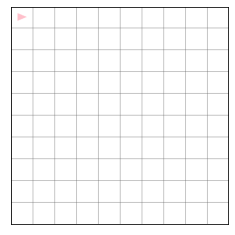

In [7]:
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
os.environ['QT_QPA_PLATFORM']='offscreen'
world = World(grid_size=10, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")
world_rgb = world.render_simple()

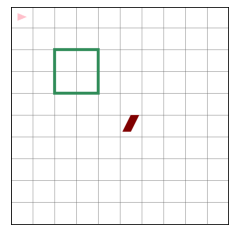

In [8]:
# try to place an object on to the map
world.clear_situation()
# world.place_object(Object(size=4, color="green", shape="box"), position=Position(row=3, column=3))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
world.place_object(Object(size=3, color="red", shape="cylinder"), position=Position(row=5, column=5))
_ = world.render_simple()

### ReaSCAN Grammer Module

In [9]:
grammer = Grammer(vocabulary)

In [12]:
grammer._sample_grammer_pattern_reascan_train()

['$OBJ_0 ^ $OBJ_1', '$OBJ_0 ^ $OBJ_1 & $OBJ_2', '$OBJ_0 ^ $OBJ_1 ^ $OBJ_2']

In [14]:
grammer.build_dependency_graph('$OBJ_0 ^ $OBJ_1 & $OBJ_2 ^ $OBJ_3 & $OBJ_4')

OrderedDict([('$OBJ_0', ['$OBJ_1', '$OBJ_2']),
             ('$OBJ_2', ['$OBJ_3', '$OBJ_4'])])

In [15]:
grammer.sample_object_relation_grammer(
    '$OBJ_0', 
    grammer.build_dependency_graph('$OBJ_0 ^ $OBJ_1 & $OBJ_2'))[:5]

[({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_COLUMN')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$IS_INSIDE')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_SIZE')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_COLOR')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_COLUMN'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_ROW')]))]

In [16]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_ROW', ('$OBJ_0', '$OBJ_2'): '$SAME_COLUMN'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'
grammer.grounding_grammer_with_vocabulary(grammer_pattern, obj_pattern_map, rel_map)

[{'$OBJ_0': 'object', '$OBJ_1': 'circle', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'object', '$OBJ_1': 'circle', '$OBJ_2': 'square'},
 {'$OBJ_0': 'object', '$OBJ_1': 'cylinder', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'cylinder', '$OBJ_2': 'square'},
 {'$OBJ_0': 'object', '$OBJ_1': 'square', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'square', '$OBJ_2': 'cylinder'}]

### ReaSCAN Simulator

In [17]:
simulator = Simulator(object_vocabulary, vocabulary, 
                      grid_size=6, 
                      random_distractor_placement_max=8, 
                      relational_distractor_placement_max=2,)

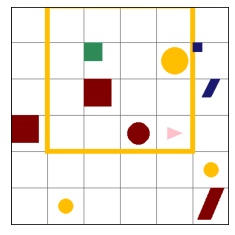

Command:
walk to the object that is in the same row as the red square and inside of the box cautiously


In [76]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$COLOR $SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_ROW', ('$OBJ_0', '$OBJ_2'): '$IS_INSIDE'}
obj_map = {'$OBJ_0': 'object', '$OBJ_1': 'red square', '$OBJ_2': 'box'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'

simulator.sample_situations_from_grounded_grammer(
    grammer_pattern, 
    obj_pattern_map, 
    rel_map, 
    obj_map)
print("Command:")
command_str = grammer.repre_str_command(grammer_pattern, rel_map, obj_map)
print(f"walk to {command_str} cautiously")

### ReaSCAN Dataset

In [15]:
class ReaSCAN(object):
    """
    This contains a couple modules:
    (1) dataset generator.
    (2) dataset splitter.
    (3) dataset stats monitor.
    (4) dataset IO operator.
    (5) dataset tensorer.
    """
    def __init__(self):
        pass